## 📋 Project Overview

This project focuses on detecting toxic user-generated content using deep learning techniques.

### Objective
Build a **binary classification model** to detect toxic comments using neural networks, with a comparative analysis of different Bag-of-Words (BOW) representations and implementation frameworks.

### Dataset
**Jigsaw Toxic Comment Classification Challenge**

### Dataset Characteristics
- Multi-label classification problem with **6 toxic categories**
- Highly imbalanced dataset  
  - ~90% non-toxic  
  - ~10% toxic
- Contains **159,571 training comments**

## 🧭 Approach

The workflow followed in this project includes:

- Exploratory Data Analysis (EDA) to understand label distribution
-Convert multi-label problem into binary classification (toxic vs non-toxic)
- Balance the dataset using undersampling
- Text preprocessing and cleaning
- Feature extraction using multiple Bag-of-Words representations:
- - Binary BOW
- - Count-based BOW
- - Term Frequency (TF)
- - TF-IDF
- Implementation and comparison using scikit-learn and Keras preprocessing modules, with analysis of normalization effects
- Training and evaluating a Deep Neural Network classifier for each representation
- Performance comparison across different BOW encoding strategies

## 🔧 Installation & Imports

Installing required libraries and importing necessary modules.

```python
!pip install upsetplot

In [1]:
!pip install upsetplot

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for upsetplot: filename=upsetplot-0.9.0-py3-none-any.whl size=24866 sha256=008da67a27d28d50bd072935c09beb068d4f284c0f9c9a7e8b3b8bab674d3dd8
  Stored in directory: /root/.cache/pip/wheels/5d/7a/54/1460364da0fe4e17c256b7a28191fa373d81292fcf73a4ddb8
Successfully built upsetplot


In [2]:
# Core data handling
import pandas as pd
import numpy as np
from collections import Counter

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from upsetplot import UpSet, from_indicators

# Text processing
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Machine learning & Deep learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import normalize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

2026-01-14 23:57:50.841152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768435071.069699      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768435071.136973      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768435071.671241      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768435071.671361      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768435071.671365      55 computation_placer.cc:177] computation placer alr

True

## 📂 1. Load Dataset

Loading the training and test datasets from the Kaggle competition.


In [3]:
# Load the dataset files
train_df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv')
test_df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv')

## 🔍 2. Exploratory Data Analysis (EDA)

Exploring the dataset to understand its structure, label distribution, and potential challenges.


In [4]:
train_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [5]:
test_df

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


### 2.1 Dataset Structure

Understanding the basic structure of the dataset including columns, data types, and missing values.

In [6]:
# info()
print("DATASET INFO")
train_df.info()

DATASET INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [7]:
# column names
print("COLUMN NAMES ONLY")
columns = train_df.columns.tolist()
print(f"Number of columns: {len(columns)}")
print(f"Column names: {columns}")


COLUMN NAMES ONLY
Number of columns: 8
Column names: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


### 2.2 Column Type Analysis

Identifying which columns are text, numerical, or label columns.

In [8]:
# Identify categorical/text vs numerical columns
text_columns = []
numerical_columns = []
categorical_columns = []

for col in train_df.columns:
    dtype = train_df[col].dtype
    if dtype == 'object':
        text_columns.append(col)
    elif dtype in ['int64', 'float64']:
        numerical_columns.append(col)
    else:
        categorical_columns.append(col)

print(f"Text columns ({len(text_columns)}): {text_columns}")
print(f"Numerical columns ({len(numerical_columns)}): {numerical_columns}")
print(f"Other ({len(categorical_columns)}): {categorical_columns}")

Text columns (2): ['id', 'comment_text']
Numerical columns (6): ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
Other (0): []


In [9]:
# Detailed column information including missing values
print("DETAILED COLUMN INFORMATION")
for col in train_df.columns:
    non_null = train_df[col].count()
    null_count = train_df[col].isnull().sum()
    dtype = train_df[col].dtype
    unique_count = train_df[col].nunique() if dtype != 'object' else "N/A (text)"
    print(f"\nColumn: {col}")
    print(f"  Non-null values: {non_null:,}")
    print(f"  Null values: {null_count:,}")

DETAILED COLUMN INFORMATION

Column: id
  Non-null values: 159,571
  Null values: 0

Column: comment_text
  Non-null values: 159,571
  Null values: 0

Column: toxic
  Non-null values: 159,571
  Null values: 0

Column: severe_toxic
  Non-null values: 159,571
  Null values: 0

Column: obscene
  Non-null values: 159,571
  Null values: 0

Column: threat
  Non-null values: 159,571
  Null values: 0

Column: insult
  Non-null values: 159,571
  Null values: 0

Column: identity_hate
  Non-null values: 159,571
  Null values: 0


### 2.3 Toxicity Distribution Analysis

Analyzing the distribution of toxic vs non-toxic comments to understand class imbalance.

In [10]:
# TOXICITY ANALYSIS
print("\n\n2️⃣ TOXICITY OVERVIEW")
print("-" * 40)
toxic_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Check if comment has ANY toxic label
has_toxic = train_df[toxic_columns].sum(axis=1) > 0
toxic_count = has_toxic.sum()
non_toxic_count = len(train_df) - toxic_count

print(f"📈 TOTAL COMMENTS: {len(train_df):,}")
print(f"✅ NON-TOXIC: {non_toxic_count:,} ({non_toxic_count/len(train_df)*100:.1f}%)")
print(f"❌ TOXIC: {toxic_count:,} ({toxic_count/len(train_df)*100:.1f}%)")

# Visual bar
print(f"\n📊 DISTRIBUTION VISUAL:")
non_toxic_bars = int(non_toxic_count/len(train_df)*50)
toxic_bars = int(toxic_count/len(train_df)*50)
print("█" * non_toxic_bars + f" Clean ({non_toxic_count/len(train_df)*100:.1f}%)")
print("█" * toxic_bars + f" Toxic ({toxic_count/len(train_df)*100:.1f}%)")



2️⃣ TOXICITY OVERVIEW
----------------------------------------
📈 TOTAL COMMENTS: 159,571
✅ NON-TOXIC: 143,346 (89.8%)
❌ TOXIC: 16,225 (10.2%)

📊 DISTRIBUTION VISUAL:
████████████████████████████████████████████ Clean (89.8%)
█████ Toxic (10.2%)


### 2.4 Toxic Category Distribution

Analyzing the frequency of each toxic category in the dataset.

In [11]:
# DETAILED TOXIC CATEGORIES
counts = train_df[toxic_columns].sum()
sorted_counts = counts.sort_values(ascending=False)

print("📋 TOXIC TYPES (sorted by frequency):")
print("-" * 40)
for category, count in sorted_counts.items():
    pct_total = (count / len(train_df)) * 100
    pct_toxic = (count / toxic_count) * 100 if toxic_count > 0 else 0
    # Visual indicator
    bars = int(count/len(train_df)*60)
    print(f"\n{category:15s}: {count:>6,} comments")
    print(f"  {pct_total:5.1f}% of all comments")
    print(f"  {pct_toxic:5.1f}% of toxic comments")
    print(f"  {'█' * bars}")

📋 TOXIC TYPES (sorted by frequency):
----------------------------------------

toxic          : 15,294 comments
    9.6% of all comments
   94.3% of toxic comments
  █████

obscene        :  8,449 comments
    5.3% of all comments
   52.1% of toxic comments
  ███

insult         :  7,877 comments
    4.9% of all comments
   48.5% of toxic comments
  ██

severe_toxic   :  1,595 comments
    1.0% of all comments
    9.8% of toxic comments
  

identity_hate  :  1,405 comments
    0.9% of all comments
    8.7% of toxic comments
  

threat         :    478 comments
    0.3% of all comments
    2.9% of toxic comments
  


## 📊 3. Data Visualization

Visualizing label distributions and relationships between toxic categories.

### 3.1 Category Frequency Plots

Visualizing the frequency of each toxic category using bar charts.

  
**Category Frequency Plots** focus on the **overall frequency of each toxic category** across the entire dataset.  
They answer the question: **Which toxic behaviors are most common?**  
Each label is counted independently, even if multiple labels appear in the same comment.

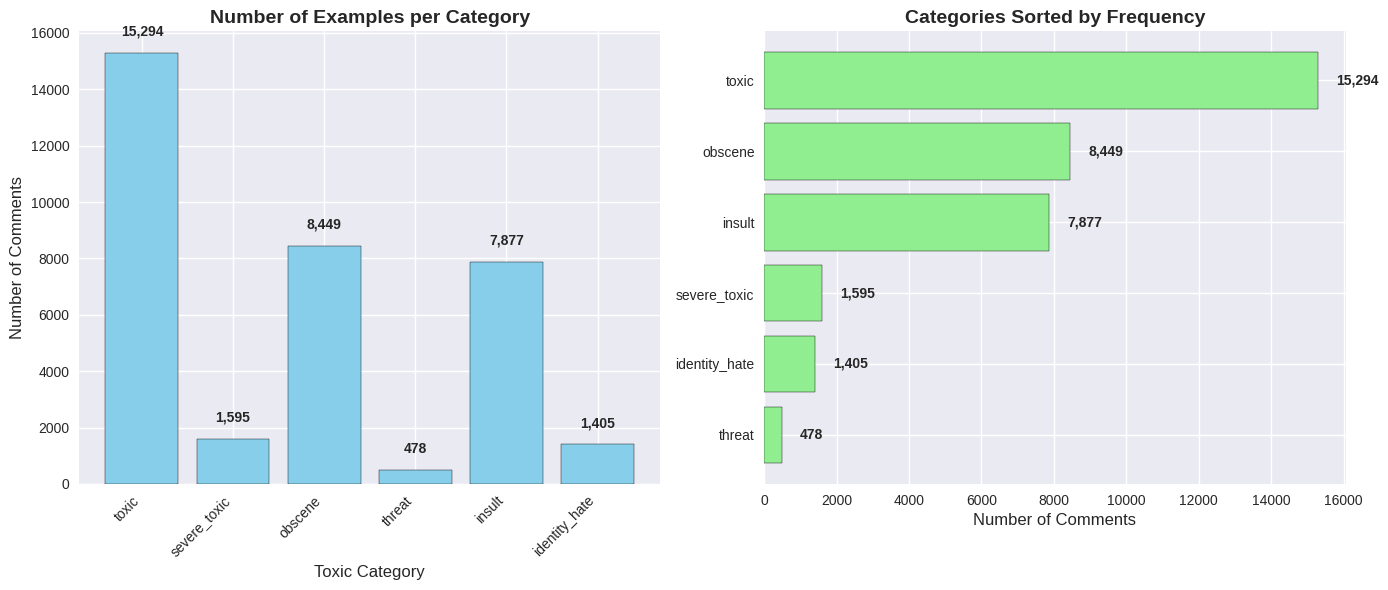

In [12]:
# Set style
plt.style.use('seaborn-v0_8')

# Calculate counts for each category
counts = train_df[toxic_columns].sum()

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))


bars1 = ax1.bar(range(len(counts)), counts.values, color='skyblue', edgecolor='black')
ax1.set_title('Number of Examples per Category', fontsize=14, fontweight='bold')
ax1.set_xlabel('Toxic Category', fontsize=12)
ax1.set_ylabel('Number of Comments', fontsize=12)
ax1.set_xticks(range(len(counts)))
ax1.set_xticklabels(counts.index, rotation=45, ha='right')

# Add count labels on top of bars
for i, (bar, count) in enumerate(zip(bars1, counts.values)):
    ax1.text(i, count + 500, f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# PLOT 2: Categories Sorted by Frequency
sorted_counts = counts.sort_values(ascending=True)
y_pos = range(len(sorted_counts))
bars2 = ax2.barh(y_pos, sorted_counts.values, color='lightgreen', edgecolor='black')
ax2.set_title('Categories Sorted by Frequency', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Comments', fontsize=12)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(sorted_counts.index)

# Add count labels on the right of bars
for i, (bar, count) in enumerate(zip(bars2, sorted_counts.values)):
    ax2.text(count + 500, i, f'{count:,}', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

### 3.2 Co-occurrence Heatmap

Visualizing how often toxic labels appear together in the same comment.

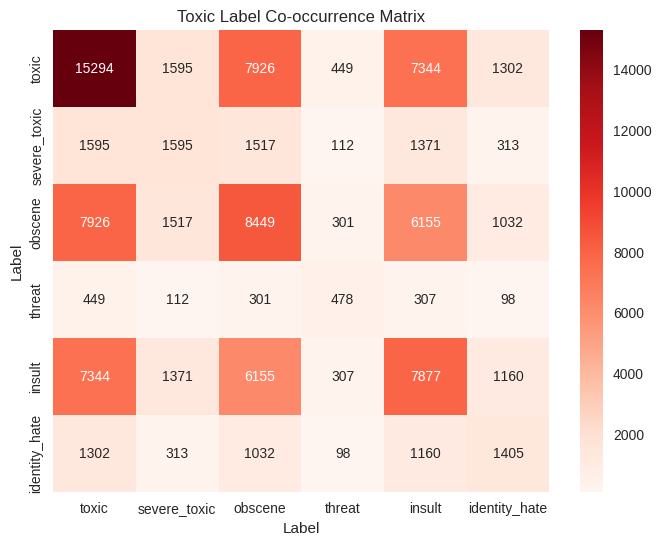

In [13]:
# Compute co-occurrence matrix
co_occurrence = train_df[toxic_columns].T.dot(train_df[toxic_columns])

plt.figure(figsize=(8,6))
sns.heatmap(
    co_occurrence,
    annot=True,
    fmt='d',
    cmap='Reds'
)

plt.title('Toxic Label Co-occurrence Matrix')
plt.xlabel('Label')
plt.ylabel('Label')
plt.show()


### 3.3 UpSet Plot – Label Overlap Analysis

Visualizing exact combinations of toxic labels.


/usr/local/lib/python3.12/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.12/dist-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

<Figure size 1000x600 with 0 Axes>

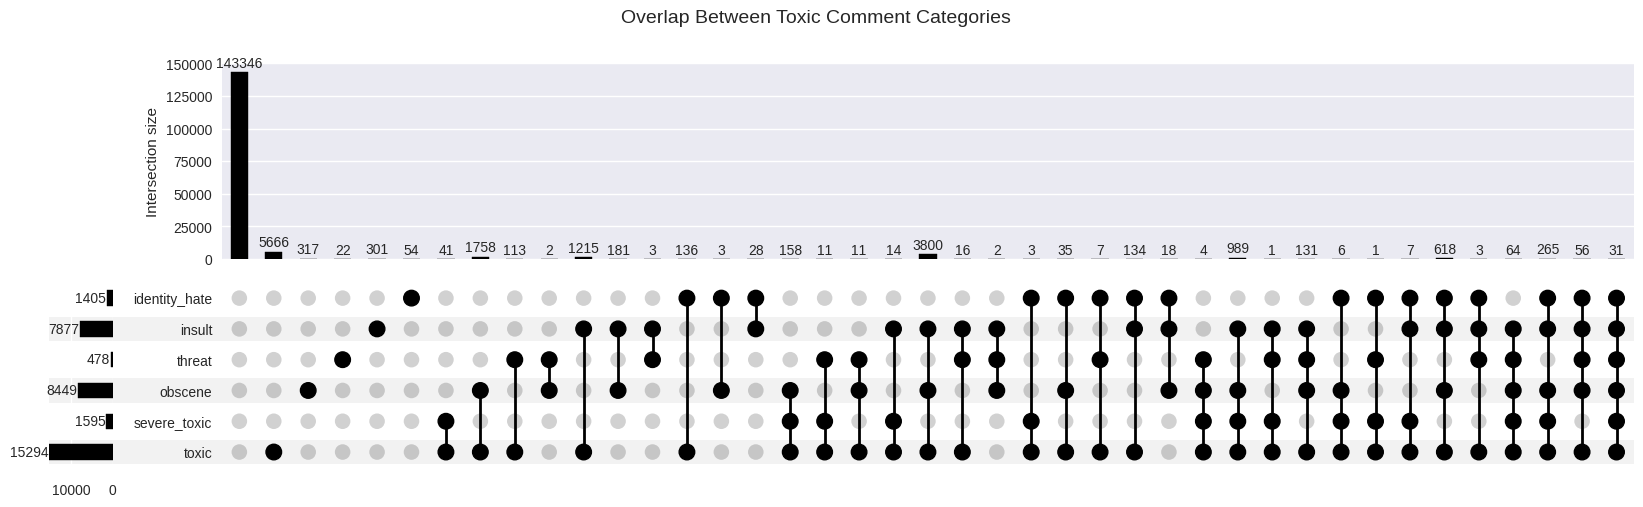

In [14]:
# Create boolean dataframe for toxic labels
label_df = train_df[toxic_columns].astype(bool)

# Convert to UpSet format
upset_data = from_indicators(toxic_columns, label_df)


plt.figure(figsize=(10,6))

UpSet(
    upset_data,
    show_counts=True,
    sort_categories_by=None
).plot()

plt.suptitle("Overlap Between Toxic Comment Categories", fontsize=14)
plt.show()


## 🔢 4. Multi-Label Analysis

Analyzing relationships and interactions between multiple toxic labels.


### 4.1 Label Count Distribution

Analyzing how many toxic labels appear in each comment.


**Label Count Distribution** focuses on the **number of toxic labels per individual comment**.  
It answers the question: **How many types of toxicity does a single comment usually contain?**  
This analysis reveals whether comments tend to be single-label or multi-label toxic.

In [15]:
# MULTI-LABEL ANALYSIS
print("\n\n4️⃣ MULTI-LABEL ANALYSIS")
print("-" * 40)

# Count labels per toxic comment
toxic_comments = train_df[has_toxic].copy()
label_counts = toxic_comments[toxic_columns].sum(axis=1)

print(f"\n📊 How many labels do toxic comments have?")
for i in range(1, 7):
    count = (label_counts == i).sum()
    pct = (count / toxic_count) * 100 if toxic_count > 0 else 0
    if count > 0:
        print(f"  {i} label(s): {count:>6,} comments ({pct:5.1f}%)")



4️⃣ MULTI-LABEL ANALYSIS
----------------------------------------

📊 How many labels do toxic comments have?
  1 label(s):  6,360 comments ( 39.2%)
  2 label(s):  3,480 comments ( 21.4%)
  3 label(s):  4,209 comments ( 25.9%)
  4 label(s):  1,760 comments ( 10.8%)
  5 label(s):    385 comments (  2.4%)
  6 label(s):     31 comments (  0.2%)


### 4.2 Top Label Combinations

Identifying the most frequent combinations of toxic labels.


In [16]:
# Most common combinations
toxic_comments['label_combo'] = toxic_comments[toxic_columns].apply(
    lambda row: '+'.join([col for col, val in zip(toxic_columns, row) if val == 1]),
    axis=1
)
top_combos = toxic_comments['label_combo'].value_counts().head(5)

for combo, count in top_combos.items():
    print(f"  {combo:<30}: {count:>6,}")

  toxic                         :  5,666
  toxic+obscene+insult          :  3,800
  toxic+obscene                 :  1,758
  toxic+insult                  :  1,215
  toxic+severe_toxic+obscene+insult:    989


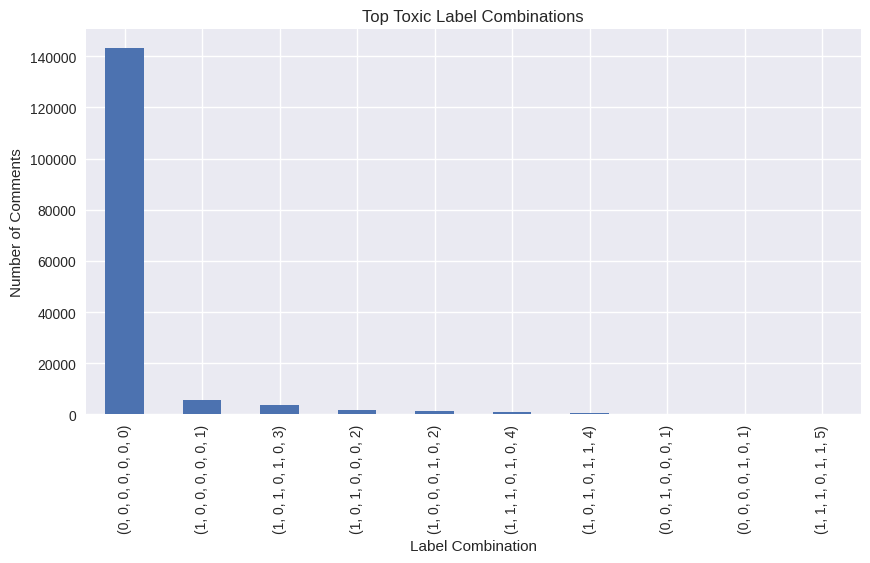

In [17]:
combo_counts = (
    train_df[toxic_columns]
    .assign(total=train_df[toxic_columns].sum(axis=1))
    .value_counts() # Count how many times each combination appears
    .head(10) # Take only the top 10 most frequent combinations
)

combo_counts.plot(kind='bar', stacked=True, figsize=(10,5))
plt.title("Top Toxic Label Combinations")
plt.ylabel("Number of Comments")
plt.xlabel("Label Combination")
plt.show()


### 4.3 Pure Label Check

Checking whether each toxic category has comments containing only that label.


In [18]:
# check all labels have pure examples or not!
for category in toxic_columns:
    pure_exists = ((train_df[category] == 1) & (train_df[toxic_columns].sum(axis=1) == 1)).any()
    print(f"{category}: {'YES' if pure_exists else 'NO'}")

toxic: YES
severe_toxic: NO
obscene: YES
threat: YES
insult: YES
identity_hate: YES


## 📈 5. Key Insights Summary

Summarizing the main findings and observations from the exploratory data analysis.


In [19]:
# SUMMARY STATISTICS
print("\n\n5️⃣ KEY INSIGHTS")
print("-" * 40)
print(f"📌 Dataset is HIGHLY IMBALANCED:")
print(f"   • {non_toxic_count/len(train_df)*100:.1f}% clean vs {toxic_count/len(train_df)*100:.1f}% toxic")
print(f"   • Model that always says 'non-toxic' would be {non_toxic_count/len(train_df)*100:.1f}% accurate!")
print(f"\n📌 Most toxic comments have 1-2 labels:")
print(f"   • Average labels per toxic comment: {label_counts.mean():.2f}")
print(f"   • Most toxic: '{counts.idxmax()}' ({counts.max():,})")
print(f"   • Least toxic: '{counts.idxmin()}' ({counts.min():,})")
print(f"\n📌 Threat is the rarest type:")
print(f"   • Only {counts['threat']:,} threat comments")
print(f"   • That's just {counts['threat']/len(train_df)*100:.2f}% of all comments")



5️⃣ KEY INSIGHTS
----------------------------------------
📌 Dataset is HIGHLY IMBALANCED:
   • 89.8% clean vs 10.2% toxic
   • Model that always says 'non-toxic' would be 89.8% accurate!

📌 Most toxic comments have 1-2 labels:
   • Average labels per toxic comment: 2.16
   • Most toxic: 'toxic' (15,294)
   • Least toxic: 'threat' (478)

📌 Threat is the rarest type:
   • Only 478 threat comments
   • That's just 0.30% of all comments


## 👀 6. Sample Data Exploration

Exploring real comment examples to understand toxic language qualitatively.


### Non-Toxic Samples

These comments contain **no toxic labels**.  
They represent normal, respectful, or neutral language.

Non-toxic samples serve as **negative examples** for the model and help it learn what *acceptable* content looks like.


In [20]:
# 1. NON-TOXIC
print("SELECT NON-TOXIC EXAMPLE:")
non_toxic_examples = train_df[train_df[toxic_columns].sum(axis=1) == 0]
non_toxic_count = len(non_toxic_examples)
print(f"Found {non_toxic_count:,} non-toxic examples")
print(f"Enter example number (1-{min(10, non_toxic_count)}): ")
choice = input()
if choice.isdigit() and 1 <= int(choice) <= min(10, non_toxic_count):
    chosen = non_toxic_examples.iloc[int(choice)-1]
    print(f"\n✓ SELECTED NON-TOXIC:")
    print(f"ID: {chosen['id']}")
    print(f"Text: {chosen['comment_text']}")
    print(f"All labels = 0")
    print(f"Length: {len(chosen['comment_text'])} chars")

SELECT NON-TOXIC EXAMPLE:
Found 143,346 non-toxic examples
Enter example number (1-10): 


 5



✓ SELECTED NON-TOXIC:
ID: 0001d958c54c6e35
Text: You, sir, are my hero. Any chance you remember what page that's on?
All labels = 0
Length: 67 chars


### Toxic Samples (Pure)

These comments contain **exactly one toxic label**.  
Each comment represents a **single type of toxic behavior**, such as insult or obscene language.

Pure toxic samples help the model learn **distinct and isolated toxicity patterns**.

In [21]:
# 2. TOXIC CATEGORIES
for category in toxic_columns:
    print(f"\n{'='*60}")
    print(f"SELECT {category.upper()} EXAMPLE:")
    
    # Try pure examples first
    pure_examples = train_df[(train_df[category] == 1) & (train_df[toxic_columns].sum(axis=1) == 1)]
    pure_count = len(pure_examples)
    
    if pure_count > 0:
        print(f"Found {pure_count} PURE examples (only {category}=1)")
        print(f"Enter example number (1-{pure_count}): ")
        choice = input()
        if choice.isdigit() and 1 <= int(choice) <= pure_count:
            chosen = pure_examples.iloc[int(choice)-1]
            print(f"\n✓ SELECTED PURE {category.upper()}:")
            print(f"ID: {chosen['id']}")
            print(f"Text: {chosen['comment_text']}")
            print(f"Label: {category}=1, others=0")
            print(f"Length: {len(chosen['comment_text'])} chars")
    else:
        # Fall back to mixed examples
        mixed_examples = train_df[train_df[category] == 1]
        mixed_count = len(mixed_examples)
        if mixed_count > 0:
            print(f"No pure examples. Found {mixed_count} MIXED examples with {category}=1")
            print(f"Enter example number (1-{mixed_count}): ")
            choice = input()
            if choice.isdigit() and 1 <= int(choice) <= mixed_count:
                chosen = mixed_examples.iloc[int(choice)-1]
                # Find other labels
                other_labels = [col for col in toxic_columns if col != category and chosen[col] == 1]
                print(f"\n✓ SELECTED MIXED {category.upper()}:")
                print(f"ID: {chosen['id']}")
                print(f"Text: {chosen['comment_text']}")
                print(f"Main label: {category}=1")
                if other_labels:
                    print(f"Also has: {', '.join(other_labels)}")
                print(f"Length: {len(chosen['comment_text'])} chars")
        else:
            print(f"No examples found for {category}")


SELECT TOXIC EXAMPLE:
Found 5666 PURE examples (only toxic=1)
Enter example number (1-5666): 


 5



✓ SELECTED PURE TOXIC:
ID: 005f59485fcddeb0
Text: "

SORRY PUCK BUT NO ONE EVER SAID DICK WAS NUMBER ONE!! But he is clearly listed as being ""second only to Batman"" and a ""master detective and martial artist"" and been trained in all the mentioned combat discplines. No need to mention in skills/abilities about the battles he's lost and won because thats not what an encylopia is supposed to do. 

Also, what your problem is your going by low end showings and not HIGH end showings where he's proven more than a match for a meta like Slade and pinned Shiva down in one of his earliest appearences.
 "
Label: toxic=1, others=0
Length: 554 chars

SELECT SEVERE_TOXIC EXAMPLE:
No pure examples. Found 1595 MIXED examples with severe_toxic=1
Enter example number (1-1595): 


 5



✓ SELECTED MIXED SEVERE_TOXIC:
ID: 018663f910e0bfe6
Text: What a motherfucking piece of crap those fuckheads for blocking us!
Main label: severe_toxic=1
Also has: toxic, obscene, insult
Length: 67 chars

SELECT OBSCENE EXAMPLE:
Found 317 PURE examples (only obscene=1)
Enter example number (1-317): 


 5



✓ SELECTED PURE OBSCENE:
ID: 051ef2d095a230cd
Text: I wish to restate the AN thread as neutral and inviting community discussion. I realize that I went to far by characterizing IH as a dick. I apologize. 140.247.141.165
Label: obscene=1, others=0
Length: 167 chars

SELECT THREAT EXAMPLE:
Found 22 PURE examples (only threat=1)
Enter example number (1-22): 


 5



✓ SELECTED PURE THREAT:
ID: 80e0b91bdea43fd3
Text: personal attacks 

dont tell me what i can and can not do i'll come over there right now and throw a brick through ur window
Label: threat=1, others=0
Length: 124 chars

SELECT INSULT EXAMPLE:
Found 301 PURE examples (only insult=1)
Enter example number (1-301): 


 5



✓ SELECTED PURE INSULT:
ID: 054b37be76678daa
Text: I'm sorry that I must say this. I have never come across a more idiotic editor on Wikipedia. Congratulations on making it to the top of my list. I mean that in a congratulatory sense entirely; in no way is it meant to offend or sound sarcastic. I wouldn't call you an editor though. You're more of a pollutant to this project and one with extreme perversion of perception. Please reread the discussion at the talk page. Based on what you last posted there it is painfully obvious that you ignored, or did not comprehend, much of what I tried explaining to you multiple times at that talk page.
Label: insult=1, others=0
Length: 593 chars

SELECT IDENTITY_HATE EXAMPLE:
Found 54 PURE examples (only identity_hate=1)
Enter example number (1-54): 


 5



✓ SELECTED PURE IDENTITY_HATE:
ID: 4d7a10ae7a7c7621
Text: "

 A hit list for Jews 
There is a site called Jew Watch out there (I'll let you find the link) which specialises in ""keeping an eye on Jewish activities"".  It is used as a reference site by anti-semites the world around.  Jew Watch makes it a point to make sure that they do not, under any circumstances, list someone who they cannot confirm 100% is Jewish.  Stormfront, a white supremist web forum, uses Jew Watch all of the time.

The criteria for inclusion on List of British Jews is the same criteria used by Jew Watch.  It is a criteria designed for anti-semites.  It is a criteria that is aimed in hurting Jews.

Jewish communities do not have such a criteria.  They allow anyone to be considered to be a Jew if they have any linkage with the Jewish community, through race, religion or culture.  This is the normal criteria that is used.  If your father is Jewish, then per Jewish community standards, you are Jewish.  And so fort

### Mixed Toxic Samples (Multi-Label)

These comments contain **more than one toxic label simultaneously**.  
They represent **multi-label toxicity**, where different harmful behaviors occur in the same comment.

Mixed samples are important because they reflect **real-world toxicity**, which is often complex and not limited to a single category.


In [22]:
# Get all comments with multiple toxic labels
mixed_examples = train_df[train_df[toxic_columns].sum(axis=1) > 1]
mixed_count = len(mixed_examples)
print(f"Found {mixed_count:,} comments with multiple toxic labels")
print(f"Enter example number (1-{mixed_count}): ")
choice = input()
if choice.isdigit() and 1 <= int(choice) <= mixed_count:
    chosen = mixed_examples.iloc[int(choice)-1]
    print(f"\n✓ SELECTED MIXED EXAMPLE:")
    print(f"Comment ID: {chosen['id']}")
    print(f"\nLABELS:")
    for col in toxic_columns:
        print(f"  {col:15s}: {chosen[col]}")
    
    # Count how many 1's it has
    num_ones = sum([chosen[col] for col in toxic_columns])
    print(f"\nThis comment has {num_ones} toxic label(s)")
    
    # Show the text
    print(f"\nFULL TEXT:")
    print("-" * 80)
    print(chosen['comment_text'])
    print("-" * 80)
    print(f"Length: {len(chosen['comment_text'])} characters")

Found 9,865 comments with multiple toxic labels
Enter example number (1-9865): 


 5



✓ SELECTED MIXED EXAMPLE:
Comment ID: 0020e7119b96eeeb

LABELS:
  toxic          : 1
  severe_toxic   : 1
  obscene        : 1
  threat         : 0
  insult         : 1
  identity_hate  : 0

This comment has 4 toxic label(s)

FULL TEXT:
--------------------------------------------------------------------------------
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!
--------------------------------------------------------------------------------
Length: 89 characters


## 🎯 7. Problem Simplification: Multi-Label → Binary

Simplifying the original multi-label task into a binary classification problem.

### Creating Binary Target Variable

Converting multiple toxic labels into a single binary target.

In [23]:
# Create a new column 'is_toxic'
train_df['is_toxic'] = train_df[toxic_columns].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

# Check results
train_df[['comment_text', 'is_toxic']].head(10)

,comment_text,is_toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [24]:
train_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,0


In [25]:
# Check results
train_df[['comment_text', 'is_toxic']].head(10)

,comment_text,is_toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


## 🧹 8. Text Preprocessing

Preparing text data for feature extraction and modeling.


### 8.1 Text Cleaning Function

Defining a text cleaning pipeline to normalize and standardize comments.


In [26]:
import re
import unicodedata
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):

    text = str(text).lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode() # emojis & non-ASCII characters

    # wordwordword → word
    text = re.sub(r'\b(\w{3,})\b(?:\1\b)+', r'\1', text)

    # hahahahaha → haha
    text = re.sub(r'(ha){3,}', r'ha', text)

    # loooooool / fuuuuuck → loool / fuuck
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    contractions = {
        r"what's": "what is",
        r"\'s": " is",
        r"\'ve": " have",
        r"can't": "cannot",
        r"cannot": "cannot",
        r"n't": " not",
        r"i'm": "i am",
        r"\'re": " are",
        r"\'d": " would",
        r"\'ll": " will",
        r"won't": "will not",
        r"don't": "do not",
        r"doesn't": "does not",
        r"didn't": "did not",
        r"hasn't": "has not",
        r"haven't": "have not",
        r"hadn't": "had not",
        r"wouldn't": "would not",
        r"shouldn't": "should not",
        r"couldn't": "could not"
    }

    for c, e in contractions.items():
        text = re.sub(c, e, text)


    text = re.sub(r'http\S+|www\S+|\S+@\S+', '', text) # Remove URLs & emails


    text = re.sub(r'[^a-z\s]', ' ', text) # Keep letters only
    text = re.sub(r'\s+', ' ', text).strip() # remove space lines


    words = [
        lemmatizer.lemmatize(w)
        for w in text.split()
        if w not in stop_words and (len(w) > 2 and len(w) < 22)
    ]

    return " ".join(words)

### 8.2 Apply Text Cleaning

Applying the text cleaning function to all comments in the dataset.


In [27]:
print("Cleaning text data..................................................")
train_df['clean_text'] = train_df['comment_text'].astype(str).apply(clean_text)

# Remove empty strings after cleaning
train_df = train_df[train_df['clean_text'].str.len() > 0].reset_index(drop=True)

Cleaning text data..................................................


In [28]:
train_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic,clean_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,aww match background colour seemingly stuck th...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,hey man really trying edit war guy constantly ...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,cannot make real suggestion improvement wonder...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,sir hero chance remember page
...,...,...,...,...,...,...,...,...,...,...
159462,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0,second time asking view completely contradicts...
159463,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0,ashamed horrible thing put talk page
159464,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0,spitzer umm there actual article prostitution ...
159465,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,0,look like actually put speedy first version de...


### 8.3 Cleaning Example Comparison

Comparing original and cleaned text to visualize preprocessing effects.


In [29]:
print("TEXT CLEANING EXAMPLE")

# Get any example
example = train_df.iloc[0]

print(f"\nORIGINAL TEXT:")
print("-" * 80)
print(example['comment_text'])

print(f"\nCLEANED TEXT:")
print("-" * 80)
print(example['clean_text'])

print(f"\nCOMPARISON:")
print(f"Original length: {len(example['comment_text'])} chars")
print(f"Cleaned length: {len(example['clean_text'])} chars")
print(f"Difference: {len(example['comment_text']) - len(example['clean_text'])} chars removed")

TEXT CLEANING EXAMPLE

ORIGINAL TEXT:
--------------------------------------------------------------------------------
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

CLEANED TEXT:
--------------------------------------------------------------------------------
explanation edits made username hardcore metallica fan reverted vandalism closure gas voted new york doll fac please remove template talk page since retired

COMPARISON:
Original length: 264 chars
Cleaned length: 156 chars
Difference: 108 chars removed


## ⚖️ 9. Handling Class Imbalance

Addressing the severe class imbalance in the dataset.


In [30]:
# BALANCE THE DATASET
toxic_df = train_df[train_df['is_toxic'] == 1]
non_toxic_df = train_df[train_df['is_toxic'] == 0]

n_toxic = len(toxic_df)
print(f"Number of toxic samples: {n_toxic}")

# Sample non-toxic to match toxic count
non_toxic_sampled = non_toxic_df.sample(n=n_toxic, random_state=42)

# Combine and shuffle
balanced_df = pd.concat([toxic_df, non_toxic_sampled])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"✅ Balanced dataset size: {len(balanced_df)}")
print(f"Class distribution:\n{balanced_df['is_toxic'].value_counts()}")

Number of toxic samples: 16215
✅ Balanced dataset size: 32430
Class distribution:
is_toxic
0    16215
1    16215
Name: count, dtype: int64


## 🔤 10. Feature Extraction

### Bag-of-Words (BOW) -> and it's Variations

In [35]:
def create_keras_bow(texts, max_features=5000, mode='count'):
    
    tokenizer = Tokenizer(num_words=max_features, oov_token='<OOV>')
    tokenizer.fit_on_texts(texts)
    
    # based on mode we create the BOW
    bow_matrix = tokenizer.texts_to_matrix(texts, mode=mode)
    
    return bow_matrix, tokenizer

In [36]:
def train_and_evaluate_model(X_train, X_test, y_train, y_test, mode_name, epochs=20):

    print(f"\n{'='*60}")
    print(f"Training with mode: {mode_name.upper()}")
    print(f"{'='*60}")
    
    # Build model
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        Dropout(0.2),
        
        Dense(1, activation='sigmoid', dtype='float32')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=0
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=0
    )
    
    # Train
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=256,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )
    
    # Evaluate
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    # Get best epoch metrics
    best_epoch = np.argmin(history.history['val_loss'])
    best_val_acc = history.history['val_accuracy'][best_epoch]
    best_val_loss = history.history['val_loss'][best_epoch]
    
    print(f"✅ Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_epoch+1})")
    print(f"✅ Best Validation Loss: {best_val_loss:.4f}")
    print(f"✅ Test Accuracy: {test_accuracy:.4f}")
    print(f"✅ Test Loss: {test_loss:.4f}")
    
    return {
        'mode': mode_name,
        'history': history,
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'best_val_accuracy': best_val_acc,
        'best_val_loss': best_val_loss,
        'epochs_trained': len(history.history['loss'])
    }

In [37]:
texts = balanced_df['clean_text'].values
labels = balanced_df['is_toxic'].values
max_features = 5000

results = []


### 10.1 SKLEARN - COUNT (NO normalization)

In [38]:
print("\n🔧 SKLEARN - COUNT (NO normalization)")
vectorizer = CountVectorizer(max_features=max_features)
X = vectorizer.fit_transform(texts)
X_train, X_test, y_train, y_test = train_test_split(
    X.toarray(), labels, test_size=0.2, stratify=labels, random_state=42
)

results.append(
    train_and_evaluate_model(X_train, X_test, y_train, y_test, 'sklearn_count')
)



🔧 SKLEARN - COUNT (NO normalization)

Training with mode: SKLEARN_COUNT


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-15 00:18:53.718528: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


✅ Best Validation Accuracy: 0.8880 (Epoch 4)
✅ Best Validation Loss: 0.2790
✅ Test Accuracy: 0.8776
✅ Test Loss: 0.2969


### 10.2 SKLEARN - COUNT (freq) -> Count + Manual Normalization

In [39]:
print("\n🔧 SKLEARN - COUNT (freq) -> Count + Manual Normalization")
vectorizer = CountVectorizer(max_features=max_features)
X = vectorizer.fit_transform(texts)
X = normalize(X, norm='l1')
# X = X / X.sum(axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X.toarray(), labels, test_size=0.2, stratify=labels, random_state=42
)

results.append(
    train_and_evaluate_model(X_train, X_test, y_train, y_test, 'sklearn_count(Count + Manual Normalization)')
)



🔧 SKLEARN - COUNT (freq) -> Count + Manual Normalization


/usr/local/lib/python3.12/dist-packages/scipy/sparse/_base.py:767: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)



Training with mode: SKLEARN_COUNT(COUNT + MANUAL NORMALIZATION)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Best Validation Accuracy: 0.8632 (Epoch 7)
✅ Best Validation Loss: 0.3529
✅ Test Accuracy: 0.8582
✅ Test Loss: 0.3757


### 10.3 SKLEARN - BINARY

In [40]:
print("\n🔧 SKLEARN - BINARY")
vectorizer = CountVectorizer(max_features=max_features, binary=True)
X = vectorizer.fit_transform(texts)

X_train, X_test, y_train, y_test = train_test_split(
    X.toarray(), labels, test_size=0.2, stratify=labels, random_state=42
)

results.append(
    train_and_evaluate_model(X_train, X_test, y_train, y_test, 'sklearn_binary')
)



🔧 SKLEARN - BINARY

Training with mode: SKLEARN_BINARY


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Best Validation Accuracy: 0.8805 (Epoch 4)
✅ Best Validation Loss: 0.2838
✅ Test Accuracy: 0.8753
✅ Test Loss: 0.2949


### 10.4 SKLEARN - TFIDF

In [41]:
print("\n🔧 SKLEARN - TFIDF")
vectorizer = TfidfVectorizer(max_features=max_features)
X = vectorizer.fit_transform(texts)

X_train, X_test, y_train, y_test = train_test_split(
    X.toarray(), labels, test_size=0.2, stratify=labels, random_state=42
)

results.append(
    train_and_evaluate_model(X_train, X_test, y_train, y_test, 'sklearn_tfidf')
)



🔧 SKLEARN - TFIDF

Training with mode: SKLEARN_TFIDF


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Best Validation Accuracy: 0.8809 (Epoch 5)
✅ Best Validation Loss: 0.2772
✅ Test Accuracy: 0.8737
✅ Test Loss: 0.2941


### 10.5 Keras count , freq , binary , and tfidf

In [42]:
modes = ['count', 'freq', 'binary', 'tfidf']

for mode in modes:

    print(f"\n🔧 KERAS - {mode.upper()}")

    X, _ = create_keras_bow(texts, max_features, mode)

    X_train, X_test, y_train, y_test = train_test_split(
        X, labels, test_size=0.2, stratify=labels, random_state=42
    )

    results.append(
        train_and_evaluate_model(X_train, X_test, y_train, y_test, f'keras_{mode}')
    )



🔧 KERAS - COUNT

Training with mode: KERAS_COUNT


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Best Validation Accuracy: 0.8888 (Epoch 5)
✅ Best Validation Loss: 0.2711
✅ Test Accuracy: 0.8868
✅ Test Loss: 0.3033

🔧 KERAS - FREQ

Training with mode: KERAS_FREQ


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Best Validation Accuracy: 0.8861 (Epoch 9)
✅ Best Validation Loss: 0.3992
✅ Test Accuracy: 0.8821
✅ Test Loss: 0.4081

🔧 KERAS - BINARY

Training with mode: KERAS_BINARY


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Best Validation Accuracy: 0.8826 (Epoch 4)
✅ Best Validation Loss: 0.2806
✅ Test Accuracy: 0.8760
✅ Test Loss: 0.2902

🔧 KERAS - TFIDF

Training with mode: KERAS_TFIDF


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Best Validation Accuracy: 0.8957 (Epoch 2)
✅ Best Validation Loss: 0.2523
✅ Test Accuracy: 0.8898
✅ Test Loss: 0.2635


In [43]:
results_df = pd.DataFrame(results)

print("\n📊 FINAL RESULTS")
print(results_df.to_string(index=False))



📊 FINAL RESULTS
                                       mode                                                        history  test_accuracy  test_loss  best_val_accuracy  best_val_loss  epochs_trained
                              sklearn_count <keras.src.callbacks.history.History object at 0x7d3818509670>       0.877582   0.296917           0.888032       0.279012               9
sklearn_count(Count + Manual Normalization) <keras.src.callbacks.history.History object at 0x7d3805a1afc0>       0.858156   0.375666           0.863172       0.352904              12
                             sklearn_binary <keras.src.callbacks.history.History object at 0x7d38058fab70>       0.875270   0.294872           0.880516       0.283800               9
                              sklearn_tfidf <keras.src.callbacks.history.History object at 0x7d38058cb620>       0.873728   0.294102           0.880902       0.277163              10
                                keras_count <keras.src.callbacks.his

/tmp/ipykernel_55/1471202883.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(results_df['mode'], rotation=45, ha='right')
/tmp/ipykernel_55/1471202883.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(results_df['mode'], rotation=45, ha='right')


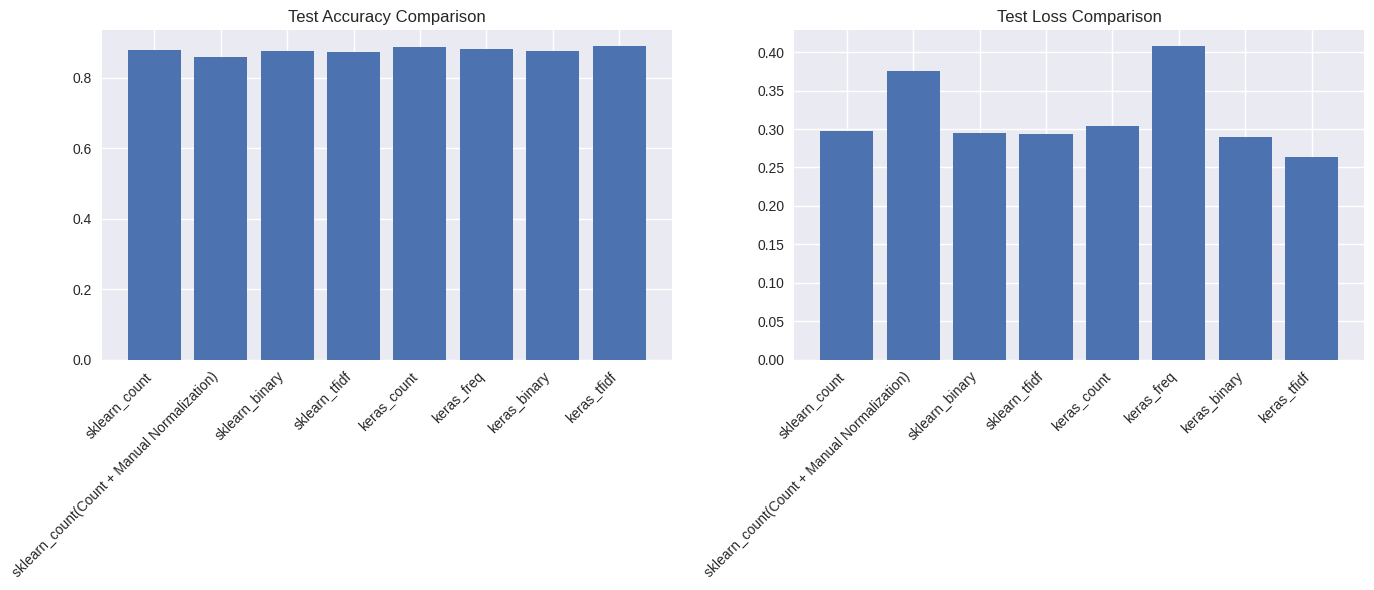

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(results_df['mode'], results_df['test_accuracy'])
axes[0].set_title('Test Accuracy Comparison')
axes[0].set_xticklabels(results_df['mode'], rotation=45, ha='right')

axes[1].bar(results_df['mode'], results_df['test_loss'])
axes[1].set_title('Test Loss Comparison')
axes[1].set_xticklabels(results_df['mode'], rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [45]:
best = results_df.loc[results_df['test_accuracy'].idxmax()]

print("\n🏆 BEST REPRESENTATION")
print(f"Method        : {best['mode']}")
print(f"Test Accuracy : {best['test_accuracy']:.4f}")
print(f"Test Loss     : {best['test_loss']:.4f}")



🏆 BEST REPRESENTATION
Method        : keras_tfidf
Test Accuracy : 0.8898
Test Loss     : 0.2635


## 📊 11. Comparison

###  11.1 Accuracies vs Losses

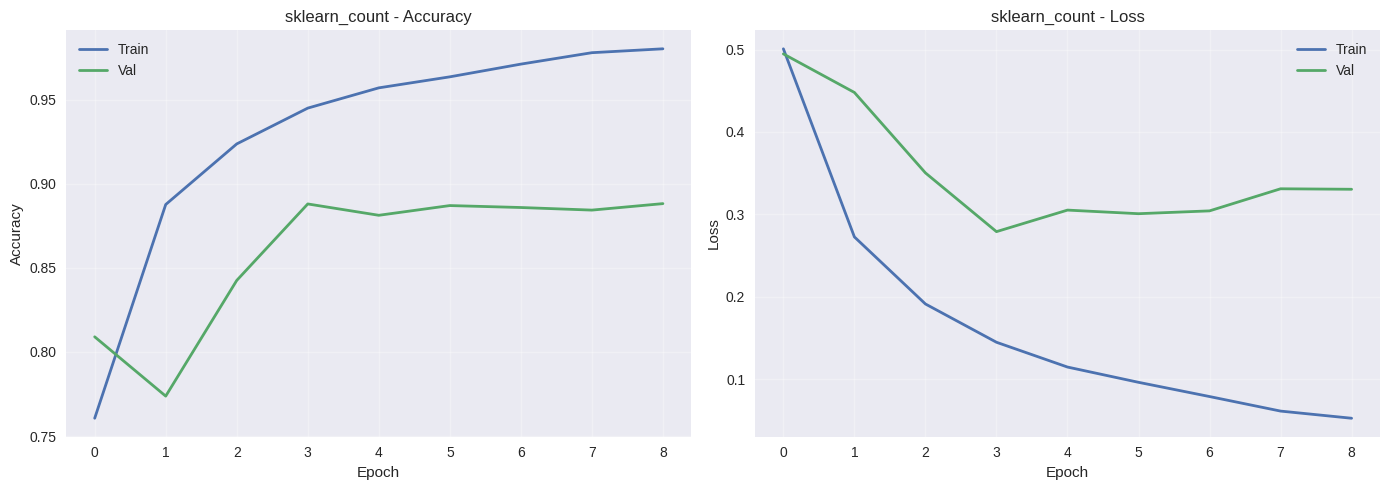

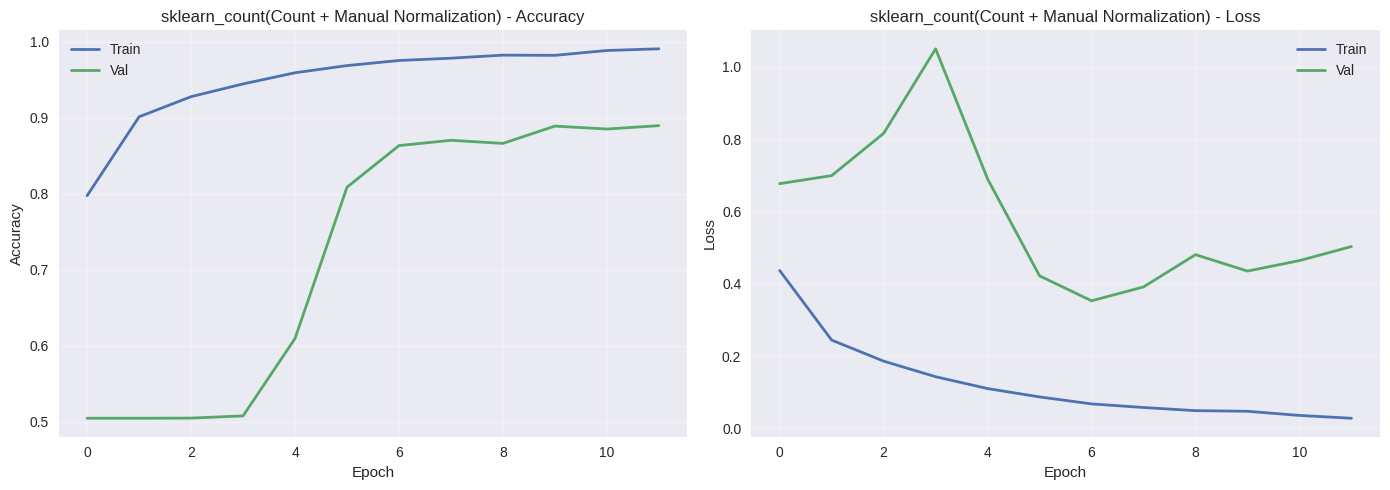

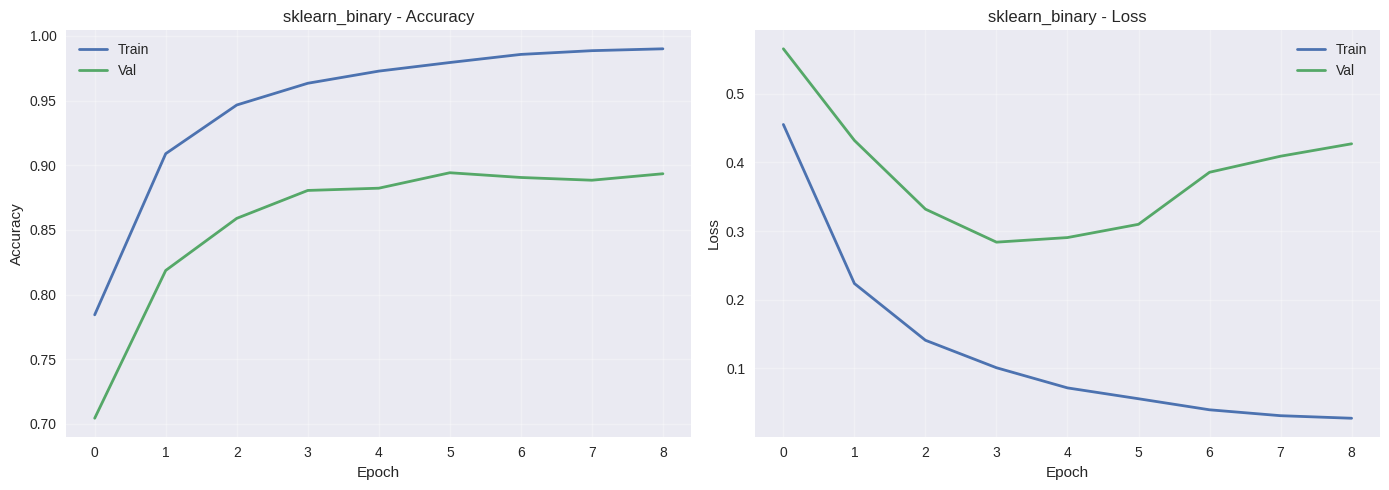

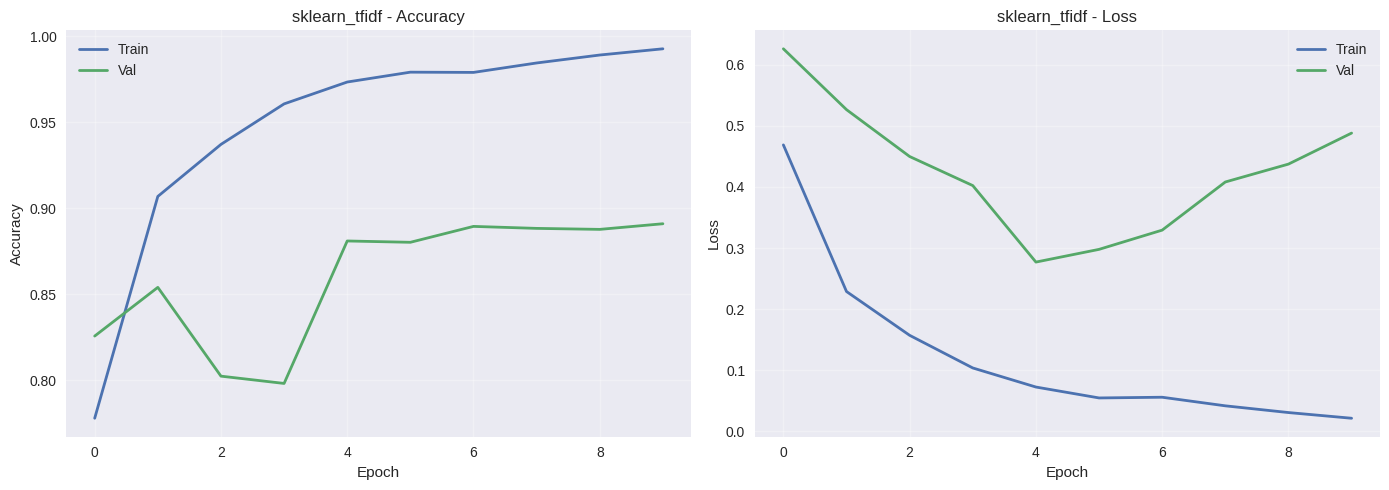

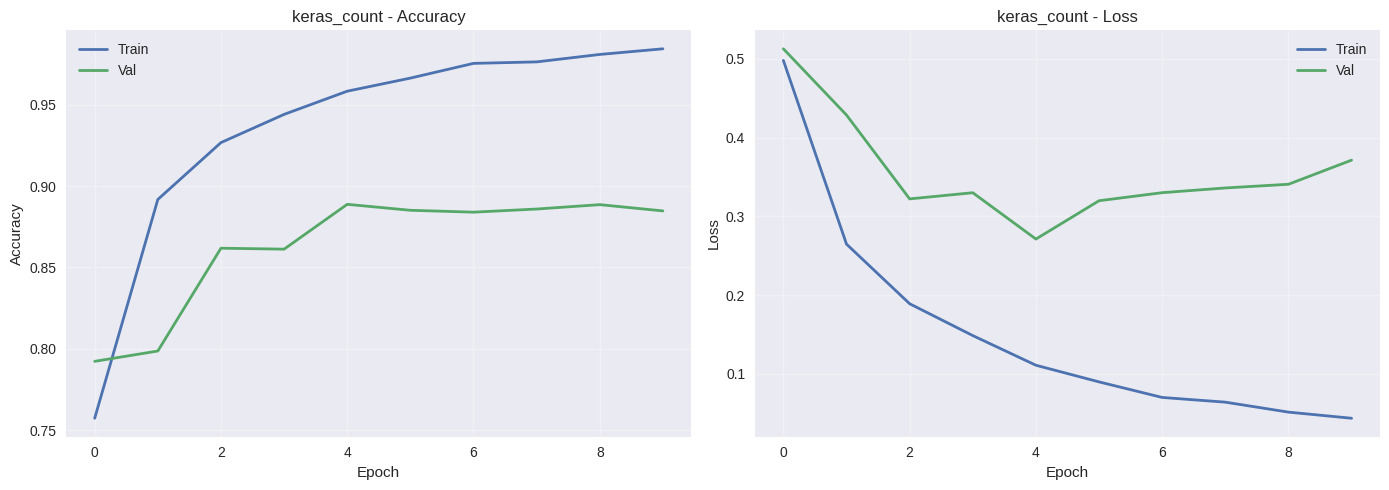

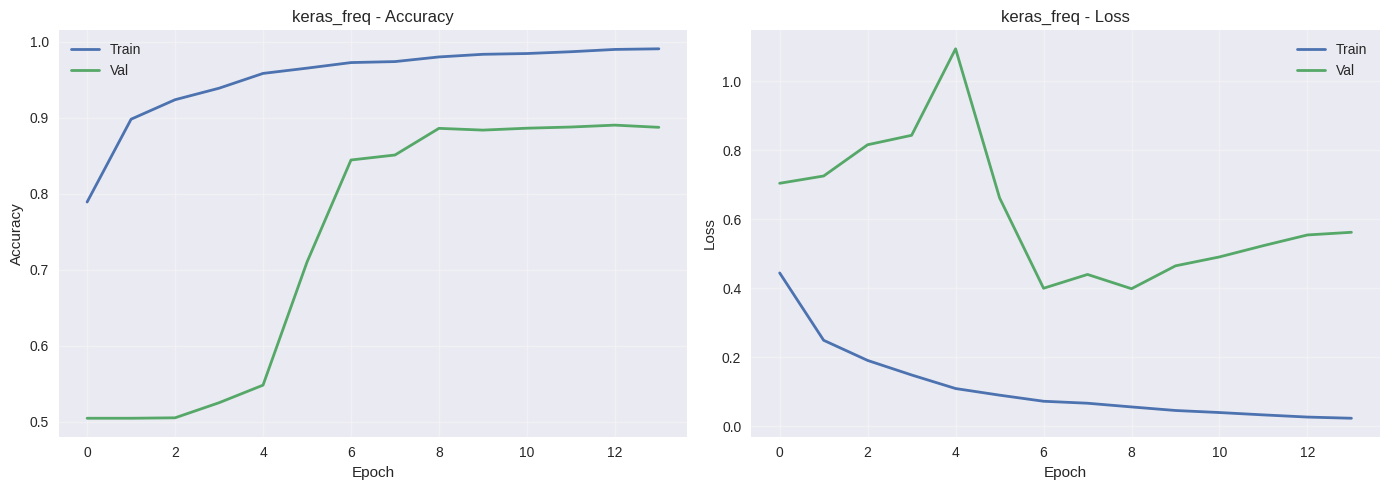

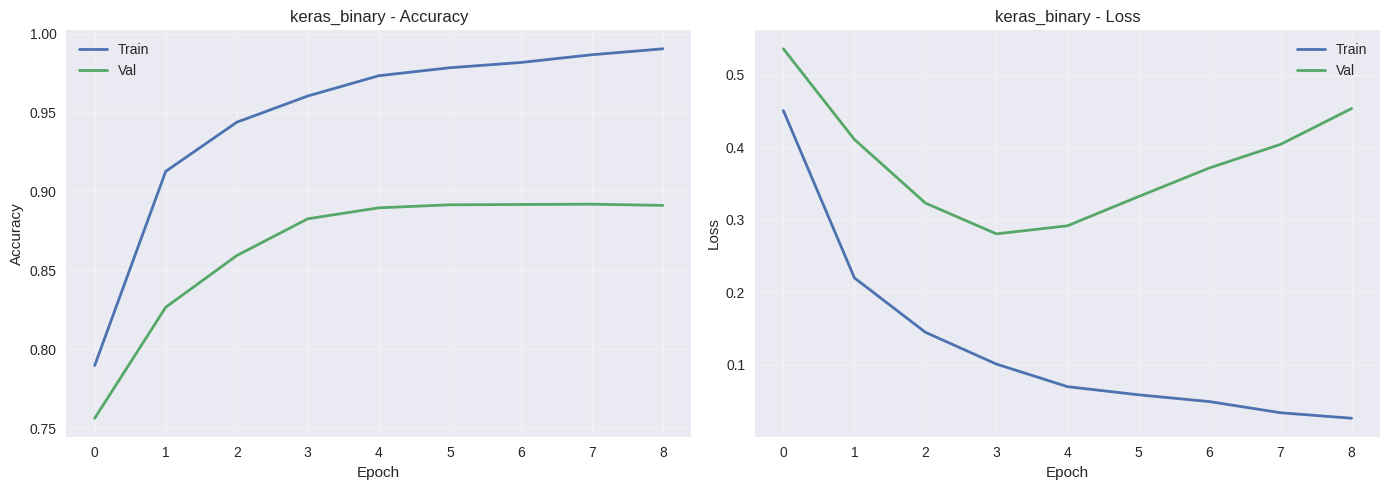

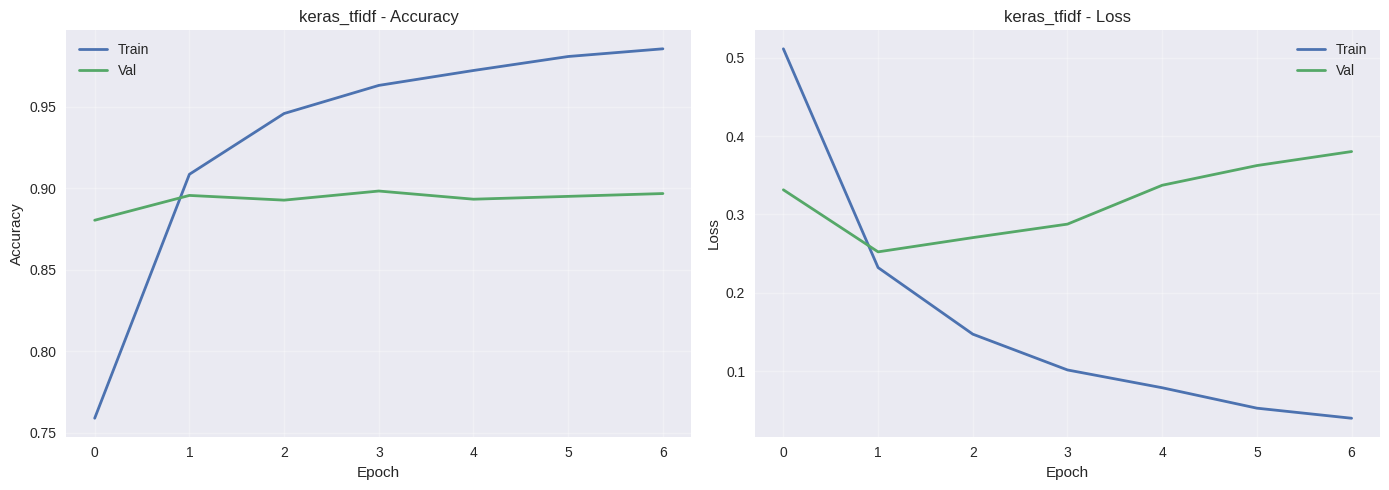

In [49]:
for res in results:
    history = res['history']
    name = res['mode']

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Val', linewidth=2)
    axes[0].set_title(f'{name} - Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss
    axes[1].plot(history.history['loss'], label='Train', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Val', linewidth=2)
    axes[1].set_title(f'{name} - Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


###  11.2 Validation Comparisons

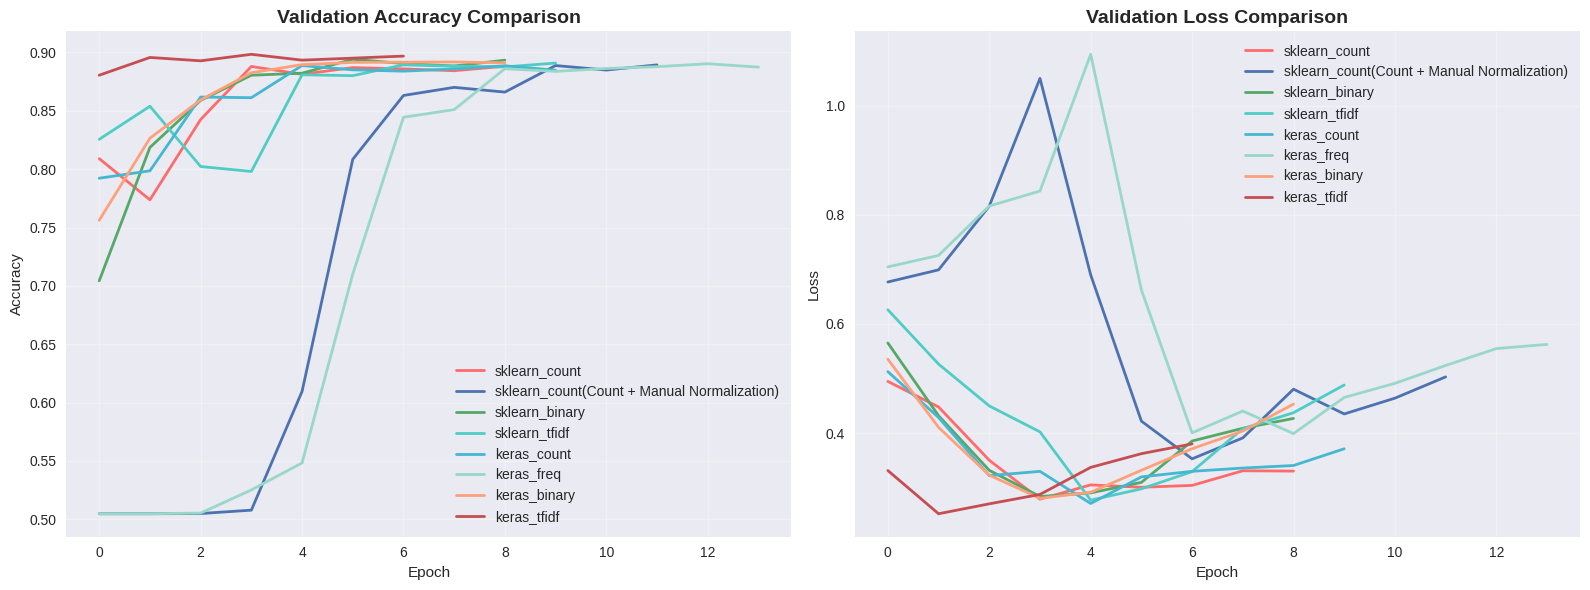

In [50]:
# Define consistent colors per method
color_map = {
    'sklearn_count': '#FF6B6B',
    'sklearn_tfidf': '#4ECDC4',
    'keras_count': '#45B7D1',
    'keras_binary': '#FFA07A',
    'keras_freq': '#98D8C8'
}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))


for res in results:
    history = res['history']
    label = res['mode']
    color = color_map.get(label, None)  # fallback if name not found

    axes[0].plot(
        history.history['val_accuracy'],
        linewidth=2,
        label=label,
        color=color
    )

axes[0].set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


for res in results:
    history = res['history']
    label = res['mode']
    color = color_map.get(label, None)

    axes[1].plot(
        history.history['val_loss'],
        linewidth=2,
        label=label,
        color=color
    )

axes[1].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
